In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,depi,vmax,time,title,cblabel,ylabel):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    # axv.set_xticklabels(np.round(np.linspace(f_lons[lonW],f_lons[lonE-1],4),2))
    
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [305]:
#Importing data and calculating section transport 

files = ['for_jan18','for_jan18_PR','backVS_jan18','backrosVS_jan18','backharoVS_jan18','forrosVS_jan18','backVS_jan18','forharoVS_jan18']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2018,12,11)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/for_straight_' + date + '_s1t21/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cstang/conda_envs/analysis-camryn/lib/pyt

### Shifting functions

In [12]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

In [147]:
def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

#### Rosario

In [72]:
VStoRosl = sectransp_2018['for_jan18'][4]
VStoRosbl = sectransp_2018['backrosVS_jan18'][4]

VStoRos = pd.Series(VStoRosl,index=datelist_vs)
VStoRosb = pd.Series(VStoRosbl,index=datelist_vs)

In [73]:
#Arbitrarily chose 0.5 and 0.5 for shift

VStoRos_sh = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0.5,0.5)
VStoRosb_sh = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-0.5,-0.5)

0.8293403955785482


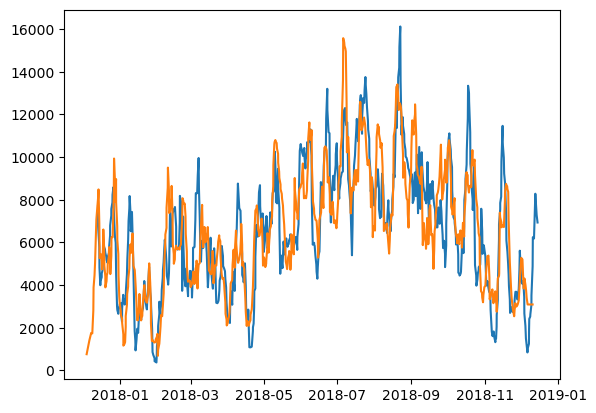

In [122]:
d1,d2,c,VStoRos_avg = merge(VStoRos_sh,VStoRosb_sh)
print(c)

plt.plot(d1.Transport)
plt.plot(d2.Transport)

Compare age of both ways

In [123]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,base,factor)
        dfr2 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],average = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.82:
            print (base, factor, corr_arr[i, j])
        

0.0 0.45 0.8271936672008791
0.05 0.45 0.8289922292029412
0.1 0.45 0.8265235621500514
0.15000000000000002 0.45 0.8250261270823152
0.2 0.45 0.8257597609889438
0.25 0.45 0.8215967706849564
0.30000000000000004 0.45 0.8228026072183194
0.35000000000000003 0.45 0.8224250692188828
0.4 0.4 0.8218528974272198
0.45 0.4 0.8277791709182514
0.5 0.4 0.8293403955785482
0.55 0.4 0.8248063259568345
0.6000000000000001 0.4 0.8200603182259993
0.65 0.4 0.8242914363614433
0.7000000000000001 0.4 0.8232121682339053
0.75 0.4 0.8234335603043834
0.8 0.4 0.8207682303173044
0.8500000000000001 0.35000000000000003 0.8217978055183592
0.9 0.35000000000000003 0.828548269655994
0.9500000000000001 0.35000000000000003 0.8259935948689054


Text(0.5, 0, 'Base')

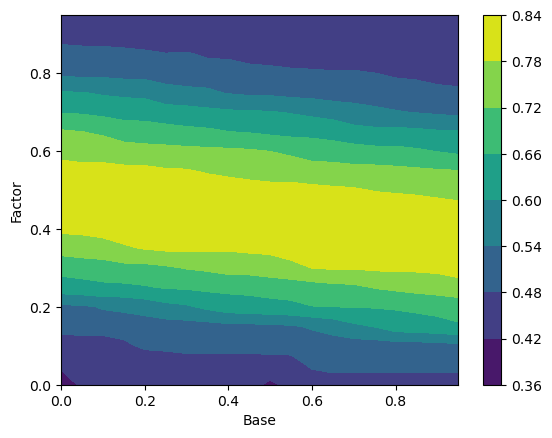

In [124]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

Try to get rid of band and get a more exact point. Equal base and factor maximizes correlation?

Text(0.5, 1.0, 'Age')

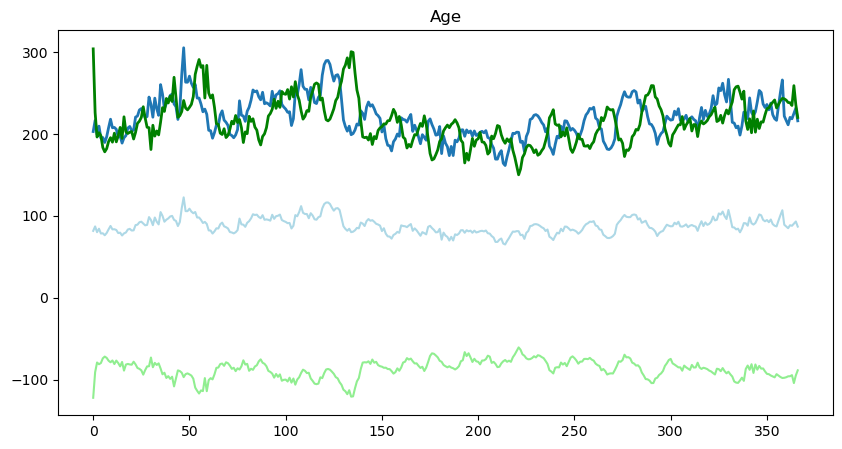

In [125]:
shift= [0.5+0.4*age for age in age_2018['for_jan18'][4]] #Base moves line up and down
shift2= [-0.5-0.4*age for age in age_2018['backrosVS_jan18'][4]]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(age_2018['for_jan18'][4],lw=2)
ax.plot(age_2018['backrosVS_jan18'][4],color='g',lw=2)
ax.plot(shift,color='lightblue')
ax.plot(shift2,color='lightgreen')
ax.set_title('Age')

In [24]:
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

print(base_arr[i_base],factor_arr[i_factor])


[0.5] [0.4]


0.8293403955785482


Text(0.5, 1.0, 'Shifted')

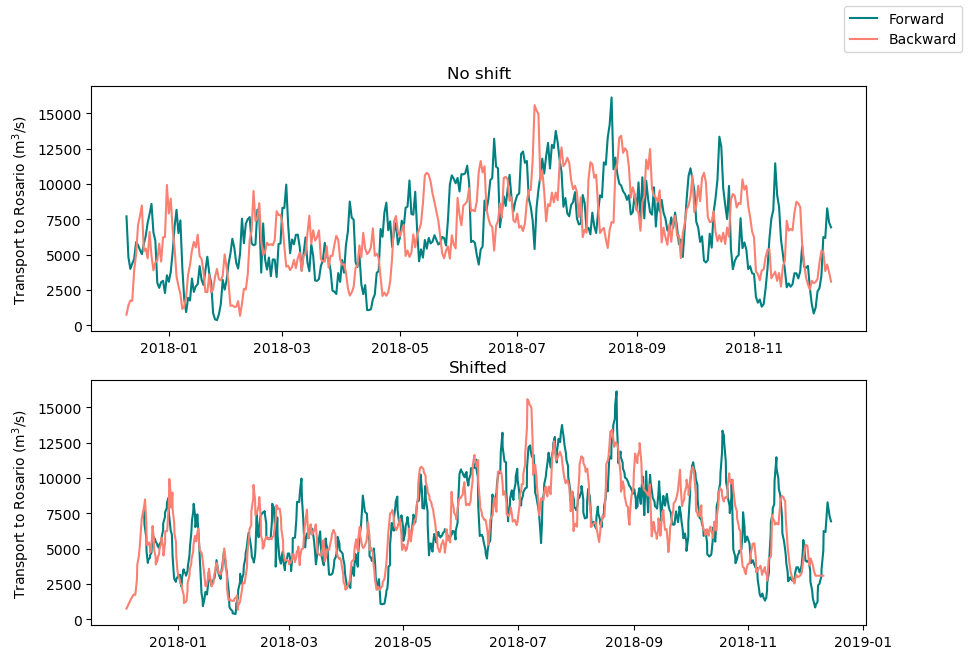

In [126]:
VStoRos_sh = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,base_arr[i_base][0],factor_arr[i_factor][0])
VStoRosb_sh = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-base_arr[i_base][0],-factor_arr[i_factor][0])

VStoRos_m,VStoRosb_m,c,VStoRos_avg = merge(VStoRos_sh,VStoRosb_sh)
print(c)

fig,ax = plt.subplots(2,1,figsize=(10,7))
ax[0].plot(VStoRos,color='teal')
ax[0].plot(VStoRosb,color='salmon')
ax[1].plot(VStoRos_m.Transport,label='Forward',color='teal')
ax[1].plot(VStoRosb_m.Transport,label='Backward',color='salmon')
fig.legend()
ax[0].set_ylabel(f'Transport to Rosario (m$^3$/s)')
ax[1].set_ylabel(f'Transport to Rosario (m$^3$/s)')
ax[0].set_title('No shift')
ax[1].set_title('Shifted')

Plot shift for different combinations of high correlation (to see how large of variation this is)

0.8271936672008791


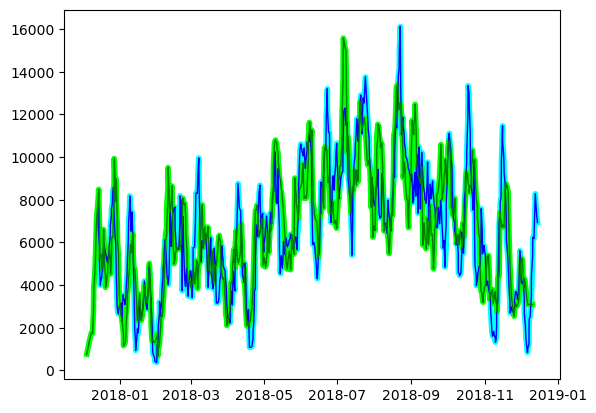

In [127]:
VStoRos_sh2 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0,0.45)
VStoRosb_sh2 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,0,-0.45)

VStoRos_m2,VStoRosb_m2,c,a = merge(VStoRos_sh2,VStoRosb_sh2)
print(c)

plt.plot(VStoRos_m.Transport,lw=4,color='cyan')
plt.plot(VStoRosb_m.Transport,color='lime',lw=4)
plt.plot(VStoRos_m2.Transport,color='blue',lw=1)
plt.plot(VStoRosb_m2.Transport,color='green',lw=1)

0.828548269655994


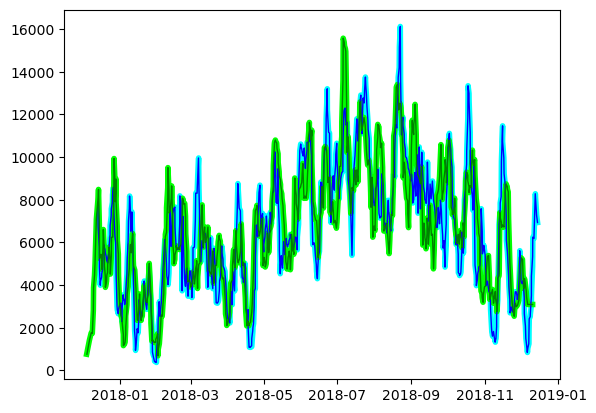

In [128]:
VStoRos_sh3 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0.9,0.35)
VStoRosb_sh3 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-0.9,-0.35)

VStoRos_m3,VStoRosb_m3,c,a = merge(VStoRos_sh3,VStoRosb_sh3)
print(c)

plt.plot(VStoRos_m.Transport,lw=4,color='cyan')
plt.plot(VStoRosb_m.Transport,color='lime',lw=4)
plt.plot(VStoRos_m3.Transport,color='blue',lw=1)
plt.plot(VStoRosb_m3.Transport,color='green',lw=1)

Actually look at how much its being shifted. Also maybe band will be different when looking at yearly scale

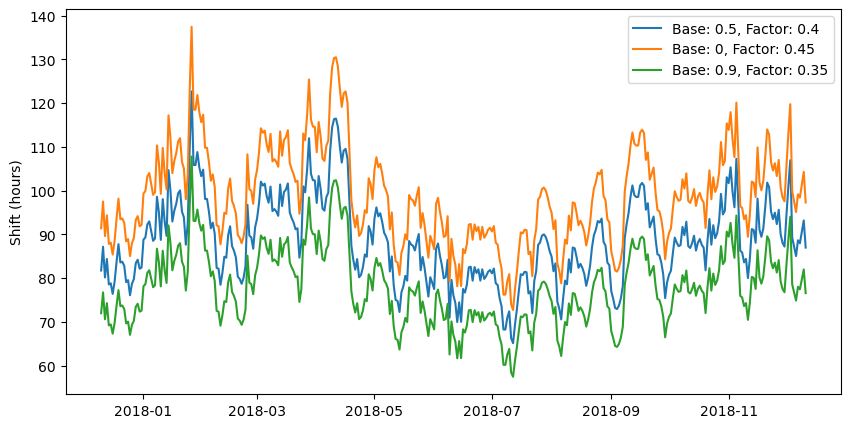

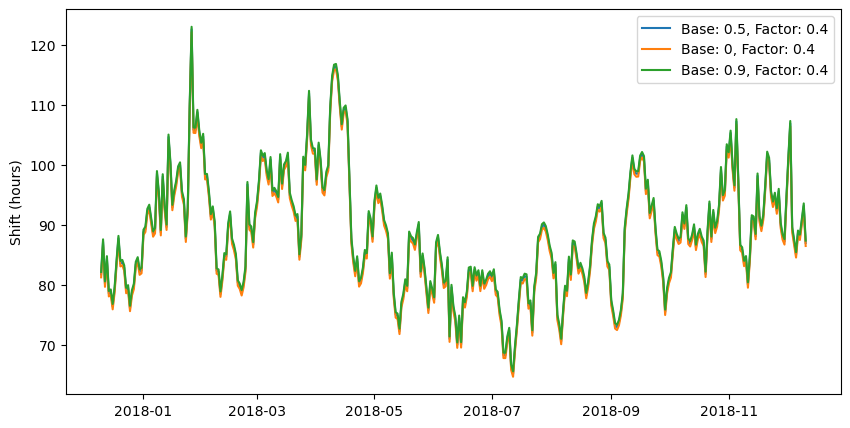

In [129]:
shift= [0.5+0.4*age for age in age_2018['for_jan18'][4]] #Base moves line up and down
shift2= [0+0.45*age for age in age_2018['for_jan18'][4]]
shift3= [0.9+0.35*age for age in age_2018['for_jan18'][4]]

plt.figure(figsize=(10,5))
plt.plot(datelist_vs,shift,label=f'Base: 0.5, Factor: 0.4')
plt.plot(datelist_vs,shift2,label=f'Base: 0, Factor: 0.45')
plt.plot(datelist_vs,shift3,label=f'Base: 0.9, Factor: 0.35')
plt.ylabel('Shift (hours)')
plt.legend()

shift= [0.5+0.4*age for age in age_2018['for_jan18'][4]] #Base moves line up and down
shift2= [0+0.4*age for age in age_2018['for_jan18'][4]]
shift3= [0.9+0.4*age for age in age_2018['for_jan18'][4]]

plt.figure(figsize=(10,5))
plt.plot(datelist_vs,shift,label=f'Base: 0.5, Factor: 0.4')
plt.plot(datelist_vs,shift2,label=f'Base: 0, Factor: 0.4')
plt.plot(datelist_vs,shift3,label=f'Base: 0.9, Factor: 0.4')
plt.ylabel('Shift (hours)')
plt.legend()


0.8259935948689054


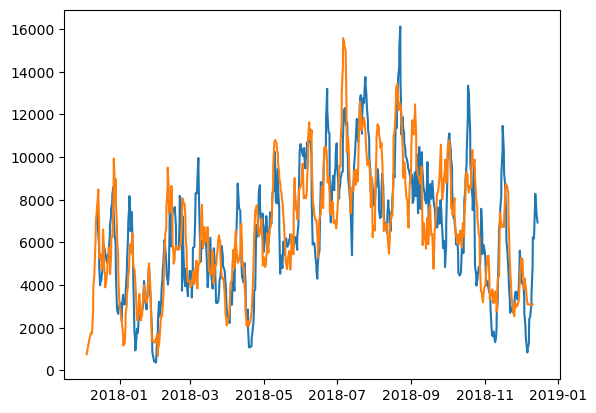

In [130]:
VStoRos_sh3 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0.95,0.35)
VStoRosb_sh3 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,-0.95,-0.35)

VStoRos_m3,VStoRosb_m3,c,a = merge(VStoRos_sh3,VStoRosb_sh3)
print(c)

plt.plot(VStoRos_m3.Transport)
plt.plot(VStoRosb_m3.Transport)

0.8271936672008791


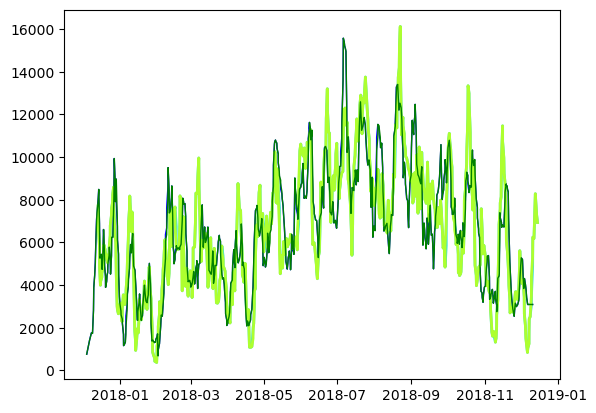

In [131]:
VStoRos_sh4 = shift_time(VStoRos,age_2018['for_jan18'][4],datelist_vs,0,0.45)
VStoRosb_sh4 = shift_time(VStoRosb,age_2018['backrosVS_jan18'][4],datelist_vs,0,-0.45)

VStoRos_m4,VStoRosb_m4,c,a = merge(VStoRos_sh4,VStoRosb_sh4)
print(c)

plt.plot(VStoRos_m.Transport,color='turquoise',lw=2)
plt.plot(VStoRosb_m.Transport,color='blue',lw=1)
plt.plot(VStoRos_m4.Transport,color='greenyellow',lw=2)
plt.plot(VStoRosb_m4.Transport,color='green',lw=1)

Although the change in shift is minor: **The maximum correlation is when base = 0.50 and factor = 0.40**

#### Look at shift with Haro

In [84]:
VStoHarol = sectransp_2018['for_jan18'][6]
VStoHarobl = sectransp_2018['backharoVS_jan18'][6]

VStoHaro = pd.Series(VStoHarol,index=datelist_vs)
VStoHarob = pd.Series(VStoHarobl,index=datelist_vs)

In [132]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoHaro,age_2018['for_jan18'][6],datelist_vs,base,factor)
        dfr2 = shift_time(VStoHarob,age_2018['backrosVS_jan18'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.88:
            print (base, factor, corr_arr[i, j])

0.45 0.15000000000000002 0.8831074661446254
0.5 0.15000000000000002 0.8818428061535413
0.65 0.1 0.8838219813783946
0.7000000000000001 0.1 0.888294521941459
0.75 0.1 0.8857246039634794
0.8 0.1 0.8855811710318306
0.8500000000000001 0.05 0.888294521941459
0.8500000000000001 0.1 0.8853172197347154
0.9 0.05 0.8855487300633135
0.9 0.1 0.8853256479946595
0.9500000000000001 0.05 0.8855487300633135
0.9500000000000001 0.1 0.8847515643386199


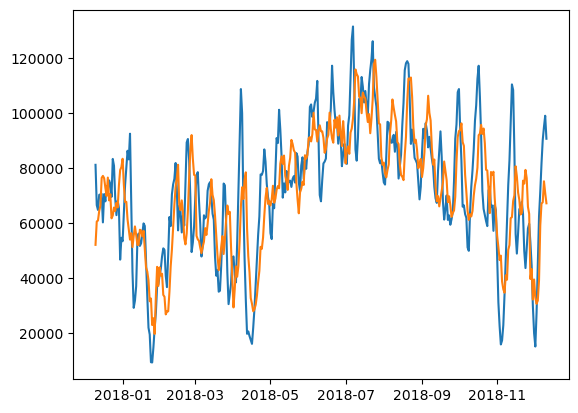

In [87]:
plt.plot(VStoHaro)
plt.plot(VStoHarob)

Text(0.5, 0, 'Base')

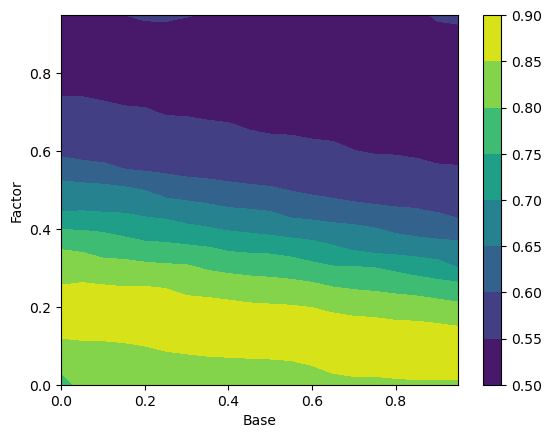

In [88]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

In [92]:
i_base_haro,i_factor_haro = np.where(corr_arr==np.max(corr_arr))

base_haro = base_arr[i_base_haro]
factor_haro = factor_arr[i_factor_haro]

print(base_arr[i_base_haro],factor_arr[i_factor_haro])

[0.7  0.85] [0.1  0.05]


Max correlation occurs at 2 locations - compare

In [148]:
VStoHaro_sh2 = shift_time(VStoHaro,age_2018['for_jan18'][6],datelist_vs,base_haro[1],factor_haro[1])
VStoHarob_sh2 = shift_time(VStoHarob,age_2018['backharoVS_jan18'][6],datelist_vs,-base_haro[1],-factor_haro[1])

VStoHaro_m2,VStoHarob_m2,c2,VStoHaro_avg = merge(VStoHaro_sh2,VStoHarob_sh2)
print(c2)

VStoHaro_sh = shift_time(VStoHaro,age_2018['for_jan18'][6],datelist_vs,base_haro[0],factor_haro[0])
VStoHarob_sh = shift_time(VStoHarob,age_2018['backharoVS_jan18'][6],datelist_vs,-base_haro[0],-factor_haro[0])

VStoHaro_m,VStoHarob_m,c,VStoHaro_avg2 = merge(VStoHaro_sh,VStoHarob_sh)
print(c)

0.8885137838951079
0.8885137838951079


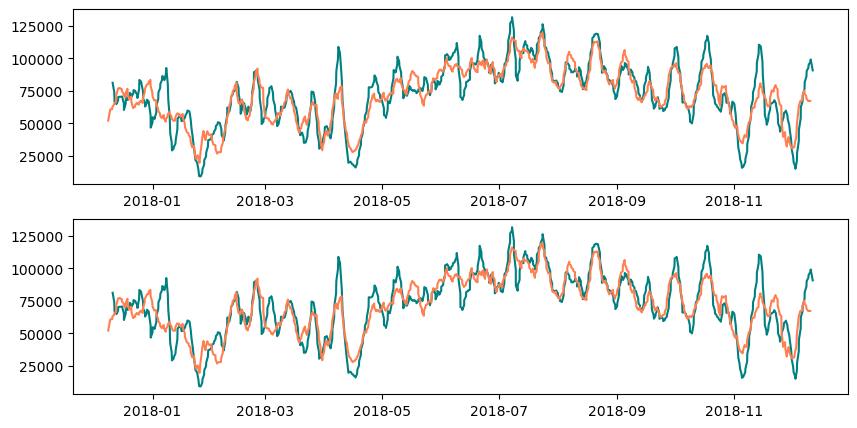

In [111]:
fig,[ax,ax2] = plt.subplots(2,1,figsize=(10,5))

ax.plot(VStoHaro_m,color='teal')
ax.plot(VStoHarob_m,color='coral')

ax2.plot(VStoHaro_m,color='teal')
ax2.plot(VStoHarob_m,color='coral')

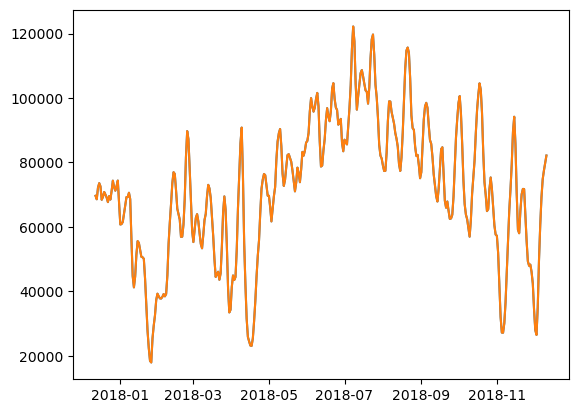

In [155]:
plt.plot(VStoHaro_avg2.dropna())
plt.plot(VStoHaro_avg.dropna())

Pretty much the exact same

#### Next steps:
 - look at correlations with tides and density difference with this shift

### Importing tidal and density difference data

In [156]:
# Importing density and tidal data

density = pd.read_csv('sigma_2018_202111_mean.csv')
dens_diff = np.array(density.south - density.north)
date_dens = pd.to_datetime(density['Unnamed: 0'])

density_ros = pd.read_csv('sigma_2018_rosariovs_202111_mean.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)
density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
dens_diff_haro = density_haro.south - density_haro.north
density_rosfpr = pd.read_csv('sigma_2018_rosariopr_202111_mean.csv')
dens_diff_rosfpr = density_rosfpr.north - density_rosfpr.south # north/south swapped for this one
density_harofpr = pd.read_csv('sigma_2018_haropr_202111_mean.csv')
dens_diff_harofpr = density_harofpr.north - density_harofpr.south # north/south swapped for this one
density_rosfprv2 = pd.read_csv('sigma_2018_rosariopr_202111_mean.csv')
dens_diff_rosfprv2 = density_rosfprv2.north - density_rosfprv2.south

tides = pd.read_csv('low_pass_tide.csv')

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2018,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)

#Confirm that the lengths are the same
print(len(datelist_dens))
print(date_dens.shape)

730
(730,)
1095
(1095,)


Text(0.5, 1.0, 'Age')

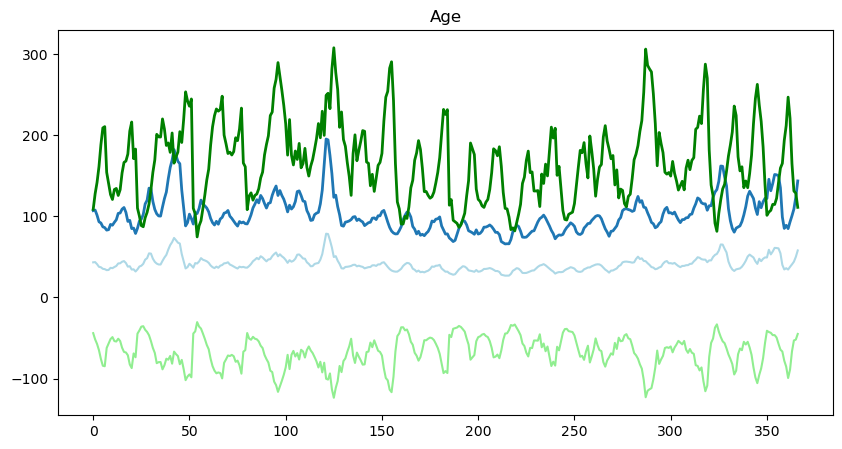

In [198]:
shift= [0.5+0.4*age for age in age_2018['for_jan18'][6]] #Base moves line up and down
shift2= [-0.5-0.4*age for age in age_2018['backrosVS_jan18'][6]]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(age_2018['for_jan18'][6],lw=2)
ax.plot(age_2018['backrosVS_jan18'][6],color='g',lw=2)
ax.plot(shift,color='lightblue')
ax.plot(shift2,color='lightgreen')
ax.set_title('Age')

### Correlation with density difference and tides - Haro

0.8233476382140206


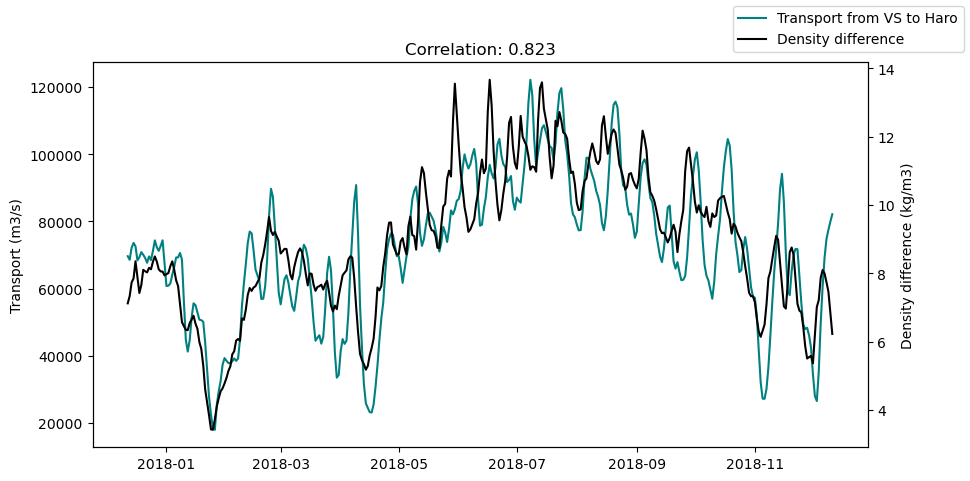

In [223]:
dateharo_sh = list(VStoHaro_avg.dropna().index)
mask = np.isin(datelist_dens,dateharo_sh)
densdiff_vs = dens_diff[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VStoHaro_avg.dropna(),label='Transport from VS to Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_vs,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

correlation,pvalue = stats.spearmanr(VStoHaro_avg.dropna(),densdiff_vs)
ax.set_title(f'Correlation: {np.round(correlation,3)}')
print(correlation)

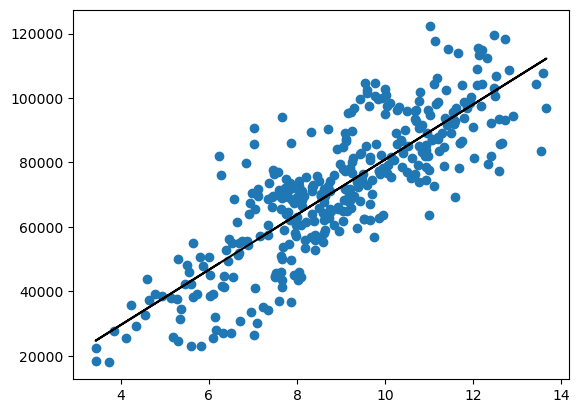

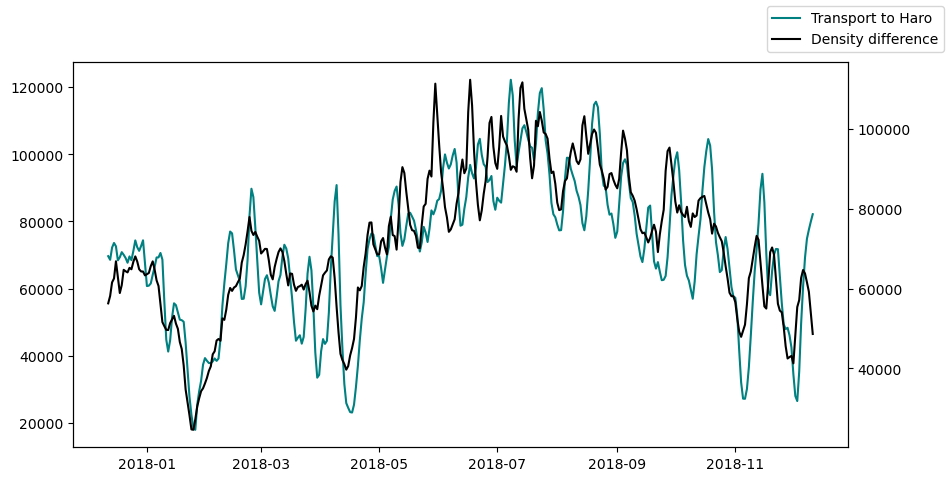

In [291]:
slope,intercept = np.polyfit(densdiff_vs,VStoHaro_avg.dropna(),1)
ddline_haro = slope*densdiff_vs+intercept
res_haro = VStoHaro_avg.dropna()-ddline_haro

plt.scatter(densdiff_vs,VStoHaro_avg.dropna())
plt.plot(densdiff_vs,ddline_haro,color='k')
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(VStoHaro_avg.dropna(),color='teal',label='Transport to Haro')
ax2=ax.twinx()
ax2.plot(dateharo_sh,ddline_haro,color='k',label='Density difference')
fig.legend()

In [292]:
intercept

-4659.926516138696

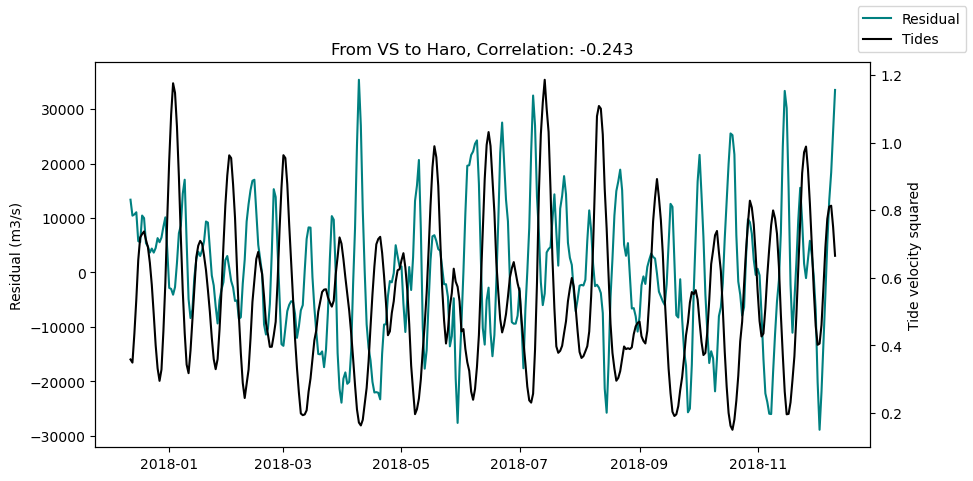

In [295]:
mask2 = np.isin(datelist_tides,dateharo_sh)

tides_vs = tides.vozocrtx[mask2]

corr,pvalue = stats.spearmanr(tides_vs,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual')
ax2=ax.twinx()
ax2.plot(dateharo_sh,tides_vs,color='k',label='Tides')
ax.set_title(f'From VS to Haro, Correlation: {np.round(corr,3)}')
ax.set_ylabel('Residual (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()

Look at if there is a different correlation in winter vs. summer

Text(0.5, 1.0, 'Correlation: -0.5251458738538484')

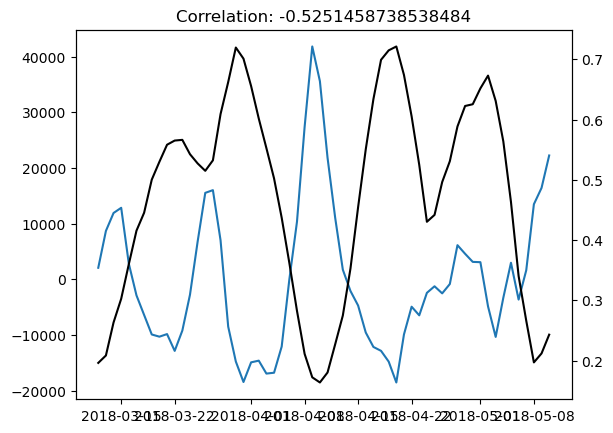

In [267]:
idx1 = 90
idx2 = 150

slope,intercept = np.polyfit(densdiff_vs[idx1:idx2],VStoHaro_avg.dropna()[idx1:idx2],1)
ddline_haro_wint = slope*densdiff_vs[idx1:idx2]+intercept
res_haro_wint = VStoHaro_avg.dropna()[idx1:idx2]-ddline_haro_wint

dateharo_shw = list(VStoHaro_avg.dropna()[idx1:idx2].index)

mask = np.isin(datelist_tides,dateharo_shw)
tides_vs_wint = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_vs_wint,VStoHaro_avg.dropna()[idx1:idx2])

fig,ax = plt.subplots()

ax.plot(res_haro_wint)
ax2=ax.twinx()
ax2.plot(dateharo_shw,tides_vs_wint,color='k')
ax.set_title(f'Correlation: {corr}')

Different correlations at different times of the year

### Correlation with tides and density difference - Rosario

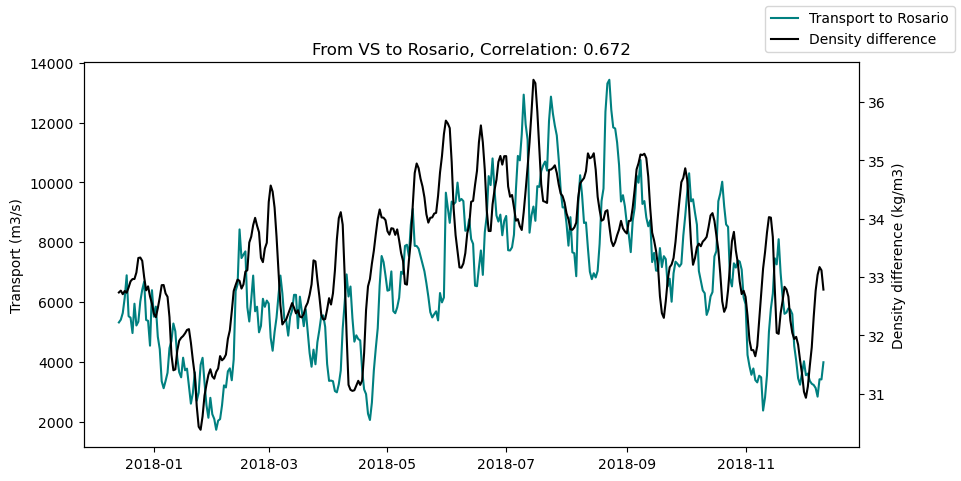

In [299]:
dateros_sh = list(VStoRos_avg.dropna().index)
VStoRos_avgd = VStoRos_avg.dropna()

mask = np.isin(datelist_dens,dateros_sh)
densdiff_ros = dens_diff_ros[mask]

corr,p = stats.spearmanr(densdiff_ros,VStoRos_avgd)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(VStoRos_avgd,'teal',label='Transport to Rosario')
ax2=ax.twinx()
ax2.plot(dateros_sh,densdiff_ros,color='k',label='Density difference')
ax.set_title(f'From VS to Rosario, Correlation: {np.round(corr,3)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

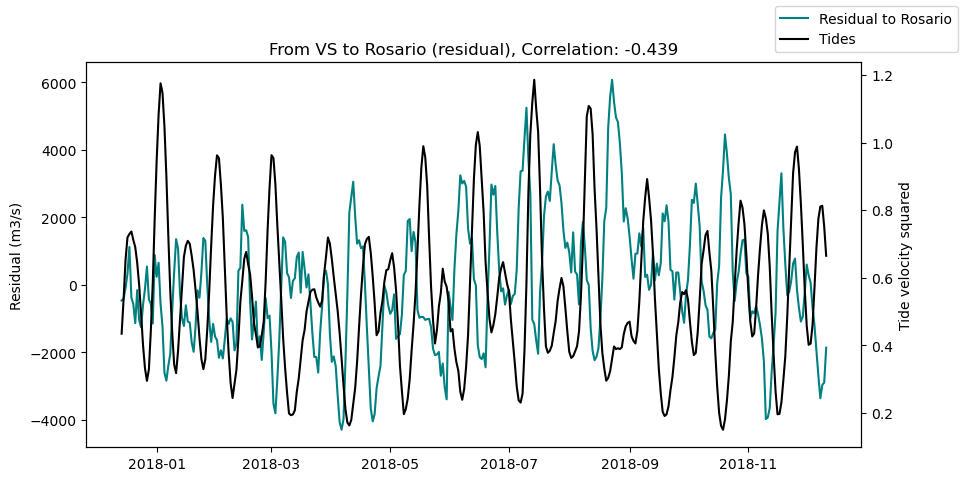

In [300]:
slope ,intercept = np.polyfit(densdiff_ros,VStoRos_avgd,1)
ddline_ros = slope*densdiff_ros+intercept
res_ros = VStoRos_avgd - ddline_ros

mask = np.isin(datelist_tides,dateros_sh)
tides_ros = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_ros,res_ros)

fig,ax = plt.subplots(figsize=(10,5))
    
ax.plot(res_ros,'teal',label='Residual to Rosario')
ax2=ax.twinx()
ax2.plot(dateros_sh,tides_ros,color='k',label='Tides')
ax.set_title(f'From VS to Rosario (residual), Correlation: {np.round(corr,3)}')
ax2.set_ylabel('Tide velocity squared')
ax.set_ylabel('Residual (m3/s)')
fig.legend()

### Surface waters (from Haro to VS)

In [306]:
HarotoVSbl = sectransp_2018['backVS_jan18'][6]
HarotoVSl = sectransp_2018['forharoVS_jan18'][6]

HarotoVS = pd.Series(HarotoVSl,index=datelist_vs)
HarotoVSb = pd.Series(HarotoVSbl,index=datelist_vs)

In [322]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(HarotoVS,age_2018['forharoVS_jan18'][6],datelist_vs,base,factor)
        dfr2 = shift_time(HarotoVSb,age_2018['backVS_jan18'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.52:
            print (base, factor, corr_arr[i, j])

-1.0 0.40000000000000124 0.5218187484100989
-0.95 0.30000000000000115 0.521620017353728
-0.7999999999999998 0.2500000000000011 0.5203414531733624
-0.7499999999999998 0.30000000000000115 0.5218187484100989
-0.6499999999999997 0.20000000000000107 0.5215139615836838
-0.49999999999999956 0.20000000000000107 0.5218187484100989
-0.24999999999999933 0.10000000000000098 0.5218187484100989


In [323]:
i_base_haros,i_factor_haros = np.where(corr_arr==np.max(corr_arr))

base_haros = base_arr[i_base_haros]
factor_haros = factor_arr[i_factor_haros]

print(base_arr[i_base_haro],factor_arr[i_factor_haro])

[-0.3  -0.15] [-0.9  -0.95]


0.4802146631319053


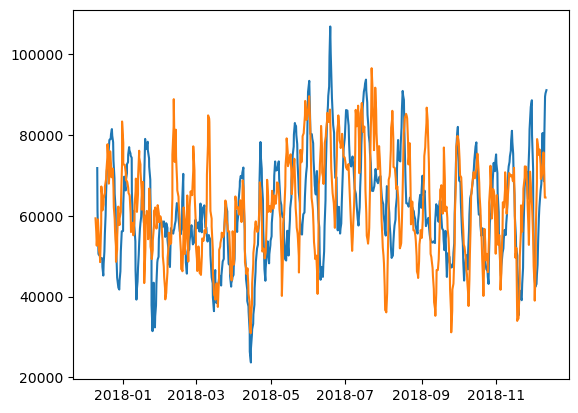

In [324]:
HarotoVS_sh = shift_time(HarotoVS,age_2018['forharoVS_jan18'][6],datelist_vs,base_arr[i_base_haro][0],factor_haros[0])
HarotoVSb_sh = shift_time(HarotoVSb,age_2018['backVS_jan18'][6],datelist_vs,-base_arr[i_base_haro][0],-factor_haros[0])

HarotoVS_m,HarotoVSb_m,c,HarotoVS_avg = merge(HarotoVS_sh,HarotoVSb_sh)
print(c)

plt.plot(HarotoVS_m.Transport)
plt.plot(HarotoVSb_m.Transport)

Text(0.5, 0, 'Base')

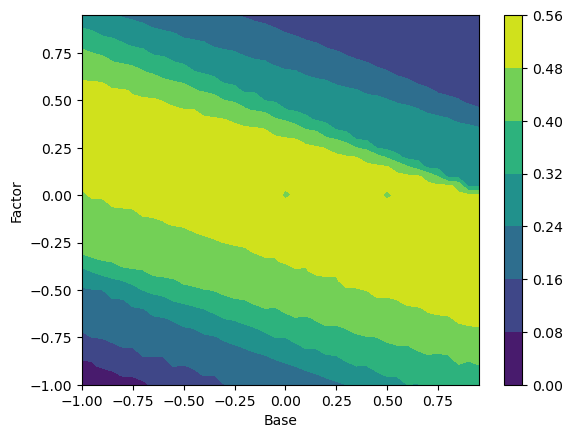

In [330]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

0.44578843763901627


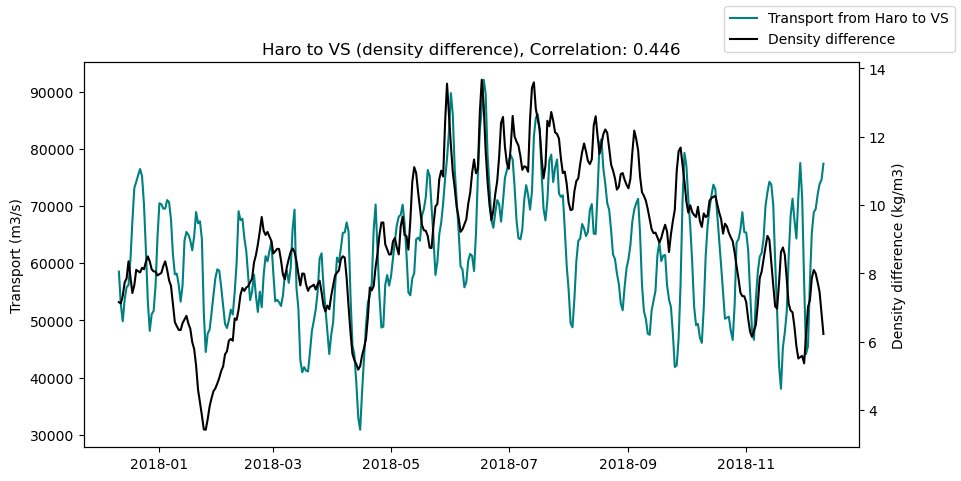

In [328]:
dateharo_sh = list(HarotoVS_avg.dropna().index)
mask = np.isin(datelist_dens,dateharo_sh)
densdiff_haro = dens_diff[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HarotoVS_avg.dropna(),label='Transport from Haro to VS',color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
fig.legend()

correlation,pvalue = stats.spearmanr(HarotoVS_avg.dropna(),densdiff_haro)
ax.set_title(f'Haro to VS (density difference), Correlation: {np.round(correlation,3)}')
print(correlation)

0.24142301274406439


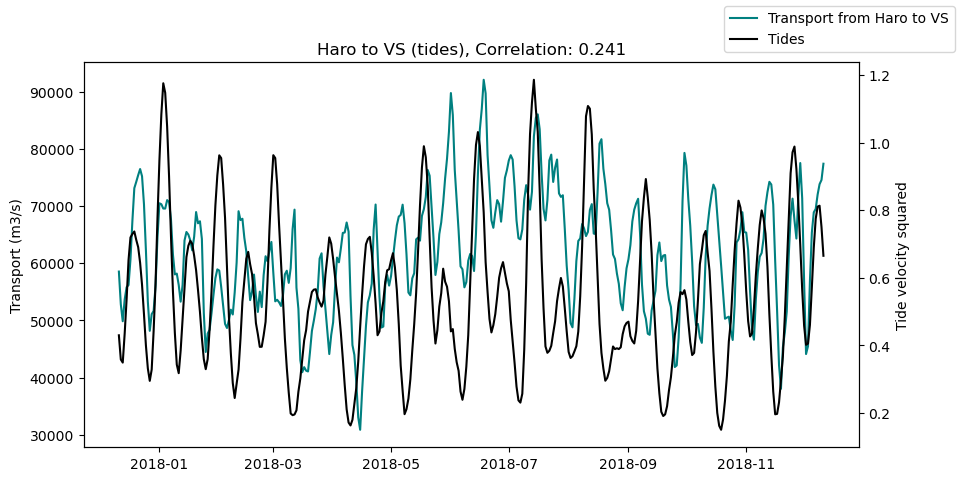

In [336]:
mask = np.isin(datelist_tides,dateharo_sh)
tides_haro = tides.vozocrtx[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(HarotoVS_avg.dropna(),label='Transport from Haro to VS',color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_tides)[mask],tides_haro,color='k',label='Tides')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()

correlation,pvalue = stats.spearmanr(HarotoVS_avg.dropna(),tides_haro)
ax.set_title(f'Haro to VS (tides), Correlation: {np.round(correlation,3)}')
print(correlation)